# Bi-LSTM & CNN for Automated Clinical Notes Annotation

Annotation in cNLP refers to the process of manually identifying the mentions of data elements of target signs, symptoms, events, etc. to be extracted in clinical notes.  Although it’s imperfect, it is an important process that provides: <br>
(1) quality control for clinical NLP output data<br>
(2) gold standards to evaluate the performance of clinical NLP tools<br>
(3) training examples to develop and improve clinical NLP tools. So that’s why we started this project.

## Part 1: Data Collection
#### This part of code is used for collecting clinical notes in xml format from a folder

In [250]:
import os
import pandas as pd
import transform_folder_to_list as tftl
import preprocess_mae as mae
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import spacy,en_core_web_sm
from pysbd.utils import PySBDFactory
import segm_prep_utils as spu

In [252]:
#Type in the folder path
folder_path=input("Type in the folder path:")

Type in the folder path:/Users/laynewei/Desktop/UCSF_intern/Data/training-PHI-Gold-Set1


In [253]:
files = []
for file in os.listdir(folder_path):
    file_path = folder_path + '/' + file
    if file_path.endswith("xml"):
        files.append(file_path)
len(files)

521

In [254]:
"""
# Here's the code using spacy_tokenizer to tokenize the text, but we end up using other tokenizer
spacy_tokenizer = spu.get_spacy_tokenizer(special_cases_file = 'special-cases-spacy.yaml')

convert = lambda x: spu.annotation_json2septext(
    ' ' + x['text'], x['seq_annotations'],
    sep = '#%#',
    tokenize = spacy_tokenizer,
    sep_label = 'punctuation',
    start = 'start',
    end = 'end',
).lower()
"""

"\n# Here's the code using spacy_tokenizer to tokenize the text, but we end up using other tokenizer\nspacy_tokenizer = spu.get_spacy_tokenizer(special_cases_file = 'special-cases-spacy.yaml')\n\nconvert = lambda x: spu.annotation_json2septext(\n    ' ' + x['text'], x['seq_annotations'],\n    sep = '#%#',\n    tokenize = spacy_tokenizer,\n    sep_label = 'punctuation',\n    start = 'start',\n    end = 'end',\n).lower()\n"

In [255]:
# get label of token based on the start index(used in label_data_frame that we'll create later):
def get_label(label_df, start):
    token_label_ =  label_df.loc[label_df.index.contains(start), "label"] 
    if len(token_label_)==0:
        return None
    else:
        return token_label_.iloc[0]

#### Create empty token_label data frame

In [256]:
column_names = ["file_name", "sentence", "token", "POS", "label","index"]
df = pd.DataFrame(columns = column_names)

In [257]:
# add PySBDFactory as a sentence_segmenter to the spacy nlp pipeline. Put it before parser
nlp = en_core_web_sm.load()
nlp.add_pipe(PySBDFactory(nlp),name='sentence_segmenter', before='parser')
# functions that display the components of the pipeline
# nlp.pipe_names

In [258]:
# n is used to count the sentences, the first sentence of the first file should be 0, 
# and the first sentence of the second file should not be 0
n=0
for i,file in enumerate(files):
    if i%20 ==0:
        print(i)
    document = tftl.convert_mae(file)
    text = document['text']
    labels = document['seq_annotations']
    # The index of the text starts from 1 rather than 0, so the index should minus 1
    label_idx = pd.IntervalIndex.from_tuples([(x["start"]-1, x["end"]-1) for x in labels], closed='left')
    label_df = pd.DataFrame(labels, index=label_idx)
   
    doc=nlp(text)
    sentences=list(doc.sents)
    for sentence in sentences:
        token_infos=[(file.split('/')[-1],n,token.text if token.pos_ != 'NUM' else 'NUM', token.pos_, get_label(label_df,token.idx),token.idx) for token in sentence]
        for token_info in token_infos:
            df.loc[len(df)]=token_info
        n+=1

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520


Check the data information

In [262]:
df.describe()

,file_name,sentence,token,POS,label,index
count,507436,507436,507436,507436,19312,507436
unique,521,48364,18443,18,26,16429
top,291-02.xml,20206,NUM,NOUN,date-date,0
freq,4527,734,32604,94057,7970,521


In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507436 entries, 0 to 507435
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   file_name  507436 non-null  object
 1   sentence   507436 non-null  object
 2   token      507436 non-null  object
 3   POS        507436 non-null  object
 4   label      19312 non-null   object
 5   index      507436 non-null  object
dtypes: object(6)
memory usage: 27.1+ MB


In [265]:
df['label'].fillna('bg',inplace=True)
df['label'].value_counts()

bg                         488124
date-date                    7970
name-doctor                  3492
location-hospital            1722
name-patient                 1659
id-medicalrecord              889
age-age                       816
contact-phone                 563
location-street               438
location-city                 342
id-idnum                      275
profession-profession         261
location-state                222
name-username                 219
location-organization         166
location-zip                  145
location-country               59
contact-fax                    25
location-location-other        12
phi-date                       12
id-device                       7
contact-url                     6
contact-email                   3
phi-doctor                      3
phi-patient                     3
id-healthplan                   2
id-bioid                        1
Name: label, dtype: int64

# Part 2 Data Manipulation
#### The ratio of bg/other label is too large,so there exist inbalanced data problem<br>
#### Possible solution:<br>
(1) Data Augmentation: Deleting sentences that doesn't have any label at all to reduce the ratio.(Used in this project)<br>
(2) Incorporate weighted_sample from keras to change the weight of different labels (If there's still a need to improve the model)<br>
(3) Try tf.keras.losses.SigmoidFocalCrossEntropy() while compiling the model

#### Data Cleaning to delete sentence that does not have label

In [298]:
new_df=df.copy()

In [299]:
new_df = new_df.groupby('sentence').filter(lambda x: len(x.loc[x.label=='bg'])!=len(x) )

In [300]:
new_df.head(30)

,file_name,sentence,token,POS,label,index
1,279-03.xml,1,record,NOUN,bg,2
2,279-03.xml,1,date,NOUN,bg,9
3,279-03.xml,1,:,PUNCT,bg,13
4,279-03.xml,1,NUM,NUM,date-date,15
5,279-03.xml,1,-,PUNCT,date-date,19
6,279-03.xml,1,NUM,NUM,date-date,20
7,279-03.xml,1,-,SYM,date-date,22
8,279-03.xml,1,NUM,NUM,date-date,23
9,279-03.xml,1,\n\n,SPACE,bg,25
16,279-03.xml,3,name,NOUN,bg,59


In [ ]:
"""
# deprecated code
num_sentences=df['sentence'].max()
for i in range(num_sentences):
    data=df.loc[df['sentence']==i]
    sentence_num=len(data)
    bg_num=len(data.loc[data.label=='bg'])
    if sentence_num==bg_num:        
        indexNames = df[df['sentence'] == i].index
        df.drop(indexNames , inplace=True)
"""


In [317]:
new_df['label'].value_counts()

bg                         101196
date-date                    7970
name-doctor                  3492
location-hospital            1722
name-patient                 1659
id-medicalrecord              889
age-age                       816
contact-phone                 563
location-street               438
location-city                 342
id-idnum                      275
profession-profession         261
location-state                222
name-username                 219
location-organization         166
location-zip                  145
location-country               59
contact-fax                    25
phi-date                       12
location-location-other        12
id-device                       7
contact-url                     6
phi-doctor                      3
contact-email                   3
phi-patient                     3
id-healthplan                   2
id-bioid                        1
Name: label, dtype: int64

## Part 3: Data preparation 
#### In this part, we are trying to calculate the number of words,labels, characters and make embeddings for them(word to index, tag to index, character to index). And we're also going to map the reversed order so that the prediction result(matrix) can be translated into tags.

In [318]:
words = list(set(new_df["token"].values))
n_words = len(words); n_words

9667

In [319]:
tags = list(set(new_df["label"].values))
n_tags = len(tags); n_tags

27

#### The sentenceGetter class can be used for retrieving sentences with their labels 

In [320]:
# retrieve sentence with labels
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(t, p, l) for t, p, l in zip(s["token"].values.tolist(),
                                                     s['POS'].values.tolist(),
                                                           s["label"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [321]:
getter = SentenceGetter(new_df)
sent = getter.get_next()


#### Here's how a sentence looks like

In [322]:
sent

[('record', 'NOUN', 'bg'),
 ('date', 'NOUN', 'bg'),
 (':', 'PUNCT', 'bg'),
 ('NUM', 'NUM', 'date-date'),
 ('-', 'PUNCT', 'date-date'),
 ('NUM', 'NUM', 'date-date'),
 ('-', 'SYM', 'date-date'),
 ('NUM', 'NUM', 'date-date'),
 ('\n\n', 'SPACE', 'bg')]

#### Get all sentences

In [323]:
sentences = getter.sentences
len(sentences)

9131

#### Introduce dictionaries of words and tags

In [324]:
max_len = 75
max_len_char = 10

In [325]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

#### Now we map the sentences to a sequence of numbers and then pad the sequence. Note that we increased the index of the words by one to use zero as a padding value. This is done because we want to use the mask_zero parameter of the embedding layer to ignore inputs with value zero.

In [326]:
X_word = [[word2idx[w[0]] for w in s] for s in sentences]
X_word[:5]

[[5139, 6925, 1818, 9498, 3895, 9498, 3895, 9498, 8717],
 [2897, 1818, 5655, 883, 1166, 5671, 8717],
 [5042, 2955, 1745, 9498, 8717],
 [6925, 1818, 3210, 7600, 8717],
 [668, 1818, 1745, 9136, 1166, 763, 9059, 5152]]

In [327]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')
X_word[0]

array([5139, 6925, 1818, 9498, 3895, 9498, 3895, 9498, 8717,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

#### Now we have to generate a dictionary for the characters we want to use and create the sequence of characters for every token. Note that we, rather arbitary, set max_len_char to 10. We could also use longer or shorter sequences. We could even use two sequences, one with the five first characters and one with the five last characters.

In [328]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars);n_chars

71

In [329]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [330]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

#### And we need to do the same mapping and padding for our tag sequence.

In [331]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')


## Part 4: LSTM & CNN

In [332]:
from sklearn.model_selection import train_test_split

In [333]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2020)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2020)

#### The trick here is, to wrap the parts that should be applied to the characters in a TimeDistributed layer to apply the same layers to every character sequence.

In [334]:
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from tensorflow.keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [335]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)

# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)

# can also try soft-max, coco-lost, focolcross
# https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)
model = Model([word_in, char_in], out)

#### Now we can compile the model as always and look at the summary.

In [336]:
import tensorflow as tf
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

# can also try sparse_categorical_crossentropy
# tf.keras.losses.SigmoidFocalCrossEntropy()

In [337]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 75, 10)]     0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 75)]         0                                            
__________________________________________________________________________________________________
time_distributed_21 (TimeDistri (None, 75, 10, 10)   730         input_16[0][0]                   
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 75, 20)       193380      input_15[0][0]                   
____________________________________________________________________________________________

In [338]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=20, validation_split=0.1, verbose=1)

Train on 7395 samples, validate on 822 samples
Epoch 1/20
7395/7395 [==============================] - 33s 4ms/sample - loss: 0.2049 - acc: 0.8284 - val_loss: 0.1222 - val_acc: 0.8390
Epoch 2/20
7395/7395 [==============================] - 27s 4ms/sample - loss: 0.1003 - acc: 0.8360 - val_loss: 0.0844 - val_acc: 0.8390
Epoch 3/20
7395/7395 [==============================] - 35s 5ms/sample - loss: 0.0746 - acc: 0.8360 - val_loss: 0.0675 - val_acc: 0.8392
Epoch 4/20
7395/7395 [==============================] - 29s 4ms/sample - loss: 0.0629 - acc: 0.8362 - val_loss: 0.0606 - val_acc: 0.8396
Epoch 5/20
7395/7395 [==============================] - 50s 7ms/sample - loss: 0.0571 - acc: 0.8407 - val_loss: 0.0560 - val_acc: 0.8613
Epoch 6/20
7395/7395 [==============================] - 33s 4ms/sample - loss: 0.0474 - acc: 0.8977 - val_loss: 0.0455 - val_acc: 0.9037
Epoch 7/20
7395/7395 [==============================] - 29s 4ms/sample - loss: 0.0404 - acc: 0.9130 - val_loss: 0.0408 - val_acc: 0

In [339]:
hist = pd.DataFrame(history.history)

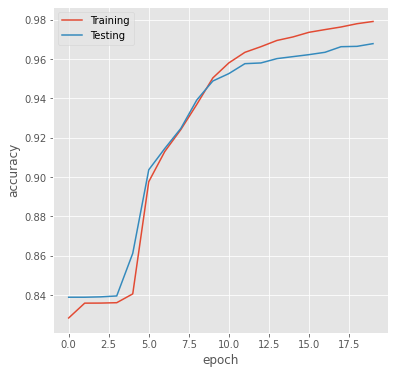

In [340]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(6,6))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(hist["acc"],label='Training')
plt.plot(hist["val_acc"],label='Testing')
plt.legend()
plt.savefig('epoch=20')
plt.show()

## Part 5: Model evaluation
#### As this is multi-class prediction, we have to change it into binary prediction to get the recall score and precision score.


In [341]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])

In [342]:
X_test=[X_word_te,np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))]
y_test=np.array(y_te).reshape(len(y_te), max_len, 1)

In [343]:
score,acc=model.evaluate(X_test,y_test,
                        batch_size=32,verbose=2)
print("test accuracy:",acc)

914/1 - 1s - loss: 0.0205 - acc: 0.9634
test accuracy: 0.96339756


In [344]:
# see how's the original prediction look like
print(y_pred[0].shape)
y_pred[0]

(75, 28)


array([[0.0000000e+00, 0.0000000e+00, 1.2516975e-06, ..., 1.7881393e-07,
        0.0000000e+00, 1.4901161e-07],
       [0.0000000e+00, 0.0000000e+00, 1.4901161e-06, ..., 1.7881393e-07,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.4901161e-07, ..., 1.7881393e-07,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [4.6662298e-01, 4.7068760e-01, 4.3208617e-01, ..., 4.5220309e-01,
        4.6792403e-01, 4.5470598e-01],
       [4.6662298e-01, 4.7068760e-01, 4.3208617e-01, ..., 4.5220309e-01,
        4.6792403e-01, 4.5470598e-01],
       [4.6662298e-01, 4.7068760e-01, 4.3208617e-01, ..., 4.5220309e-01,
        4.6792403e-01, 4.5470598e-01]], dtype=float32)

#### See some sample predictions

In [345]:
print("{:25}||{:25}||{:20}".format("Word", "True", "Pred"))
print(70 * "=")
n=0
for i in range(len(y_pred)):
    p = np.argmax(y_pred[i], axis=-1)
    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
            if idx2tag[pred]!='bg':
                n+=1
                print("{:25}: {:25} {:20}".format(idx2word[w], idx2tag[t], idx2tag[pred]))
        if n == 100 :
            break
    if n==100:
        break

Word                     ||True                     ||Pred                
shoemaker                : name-doctor               name-doctor         
NUM                      : date-date                 date-date           
NUM                      : date-date                 date-date           
NUM                      : date-date                 date-date           
2/11/81                  : date-date                 date-date           
wheeling                 : location-hospital         location-hospital   
clinic                   : location-hospital         location-hospital   
beverly                  : name-doctor               name-doctor         
thiel                    : name-doctor               name-doctor         
NUM                      : age-age                   age-age             
NUM                      : date-date                 date-date           
dotson                   : name-doctor               name-doctor         
NUM                      : bg        

In [346]:
tp,tn,tp,fn=0,0,0,0
for i in range(len(y_pred)):
    p = np.argmax(y_pred[i], axis=-1)
    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
            if idx2tag[t]!='bg' and idx2tag[pred]!='bg':
                tp+=1
            if idx2tag[t]=='bg' and idx2tag[pred]=='bg':
                tn+=1
            if idx2tag[t]=='bg' and idx2tag[pred]!='bg':
                fp+=1
            if idx2tag[t]!='bg' and idx2tag[pred]=='bg':
                fn+=1
print('\nConfusion matrix:')
print('  tp:{:5}'.format(tp),'fn:{:5}'.format(fn))
print('  fp:{:5}'.format(fp),'tn:{:5}'.format(tn),'\n')
print('precision:', tp/(tp + fp),'\n')
print('recall:', tp/(tp + fn),'\n')
print('acc:', (tp + tn)/(tp + tn + fp + fn))


Confusion matrix:
  tp: 1725 fn:  219
  fp:  909 tn: 9399 

precision: 0.6548974943052391 

recall: 0.8873456790123457 

acc: 0.9079333986287953
